In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load data from Google Drive
file_paths = ['run_1.csv', 'run_2.csv', 'stand_1.csv', 'stand_2.csv', 'walk_1.csv', 'walk_2.csv']
dataframes = []
for file_name in file_paths:
    df = pd.read_csv(f'/content/drive/My Drive/Colab Notebooks/RSW/{file_name}')
    activity = file_name.split('_')[0]
    df['Activity'] = activity
    dataframes.append(df)

In [5]:
# Combine all dataframes into one
combined_data = pd.concat(dataframes)

In [6]:
print(combined_data)

               Time (s)  Accel_X  Accel_Y  Accel_Z  Gyro_X  Gyro_Y  Gyro_Z  \
0.000000       0.980000     0.04     0.18    -0.49   -0.43   -1.28   36.73   
0.001965       0.990000     0.05     0.18    -1.89    0.55   -0.73   36.28   
0.002964       0.980000     0.05     0.18    -2.81    1.46   -0.73   36.36   
0.002964       0.980000     0.05     0.17    -1.95    2.26   -0.37   36.89   
0.004472       0.990000     0.05     0.17    -0.73    3.36   -0.67   36.41   
...                 ...      ...      ...      ...     ...     ...     ...   
2923.000000  299.555337     1.15     0.11     0.35    6.47  -24.29   -4.46   
2924.000000  299.665436     0.97    -0.22     0.22   -5.92  -24.90   -4.76   
2925.000000  299.774920     0.99    -0.10     0.25  -28.87   19.35  -16.42   
2926.000000  299.884606     0.68     0.03     0.27  -11.29   23.38   14.65   
2927.000000  299.994343     0.84    -0.09     0.35   -6.35    1.40    6.41   

             Mag_X  Mag_Y  Mag_Z Activity  
0.000000     37.11 

In [9]:
# Handle missing values
combined_data['Mag_Z'].fillna(0, inplace=True)

In [ ]:
# # Interpolate to 50 Hz
# numerical_columns = combined_data.columns.difference(['Activity', 'Time (s)'])
# numerical_data = combined_data[numerical_columns]
# original_time = combined_data['Time (s)']
# new_time = np.arange(original_time.min(), original_time.max(), 1/50.0)  # New time vector for 50 Hz

# interpolated_data = pd.DataFrame()
# for column in numerical_columns:
#     # Remove duplicate time values by averaging
#     unique_time, indices = np.unique(original_time, return_index=True)
#     unique_values = numerical_data.iloc[indices][column]

#     interp_func = interp1d(unique_time, unique_values, kind='cubic', fill_value='extrapolate')
#     interpolated_data[column] = interp_func(new_time)


In [10]:
# # Reattach the Activity labels
# activity_mapping = combined_data.set_index('Time (s)')['Activity']
# #interpolated_data['Activity'] = [activity_mapping[original_time[original_time <= t].max()] for t in new_time]
# combined_data['Activity'] = [activity_mapping[original_time[original_time <= t].max()] for t in new_time]

In [45]:
# Feature Engineering (window size, aggregation)
window_size = 10  # Number of samples in each window (1 second at 50 Hz)
features = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Mag_X', 'Mag_Y', 'Mag_Z']
aggregated_features = []

for start in range(0, len(combined_data), window_size):
    end = start + window_size
    if end <= len(combined_data):
        window = combined_data.iloc[start:end]
        mean_features = window[features].mean().tolist()
        std_features = window[features].std().tolist()
        activity_label = window['Activity'].iloc[0]
        aggregated_features.append(mean_features + std_features + [activity_label])

In [46]:
# Create DataFrame from aggregated features
column_names = [f'{feature}_mean' for feature in features] + [f'{feature}_std' for feature in features] + ['Activity']
features_df = pd.DataFrame(aggregated_features, columns=column_names)

In [47]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(features_df.drop('Activity', axis=1))

In [48]:
# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(features_df['Activity'])
y_categorical = to_categorical(y)

In [49]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.4, random_state=42)

In [50]:
# Neural Network Model
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])

In [51]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
30/30 [==============================] - 1s 11ms/step - loss: 0.7678 - accuracy: 0.7077 - val_loss: 0.3996 - val_accuracy: 0.9434
Epoch 2/50
30/30 [==============================] - 0s 4ms/step - loss: 0.3748 - accuracy: 0.9127 - val_loss: 0.2036 - val_accuracy: 0.9434
Epoch 3/50
30/30 [==============================] - 0s 4ms/step - loss: 0.2643 - accuracy: 0.9327 - val_loss: 0.1872 - val_accuracy: 0.9434
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.2261 - accuracy: 0.9453 - val_loss: 0.1795 - val_accuracy: 0.9434
Epoch 5/50
30/30 [==============================] - 0s 5ms/step - loss: 0.2233 - accuracy: 0.9390 - val_loss: 0.1762 - val_accuracy: 0.9434
Epoch 6/50
30/30 [==============================] - 0s 5ms/step - loss: 0.1859 - accuracy: 0.9464 - val_loss: 0.1693 - val_accuracy: 0.9434
Epoch 7/50
30/30 [==============================] - 0s 5ms/step - loss: 0.1853 - accuracy: 0.9516 - val_loss: 0.1619 - val_accuracy: 0.9528
Epoch 8/50
30/30 [=

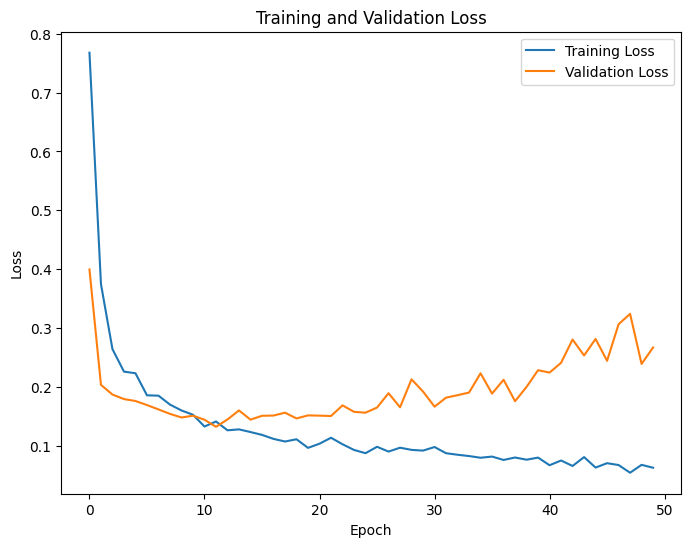

In [53]:
# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

23/23 [==============================] - 0s 4ms/step


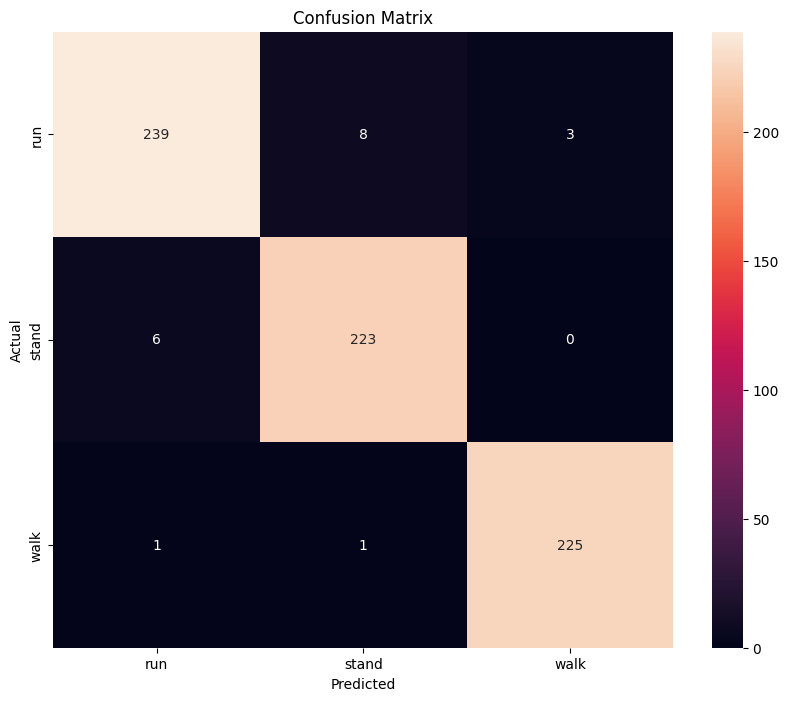

Classification Report:
              precision    recall  f1-score   support

         run       0.97      0.96      0.96       250
       stand       0.96      0.97      0.97       229
        walk       0.99      0.99      0.99       227

    accuracy                           0.97       706
   macro avg       0.97      0.97      0.97       706
weighted avg       0.97      0.97      0.97       706



In [54]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Decode the encoded labels back to original labels
actual_labels = encoder.inverse_transform(y_true)
predicted_labels = encoder.inverse_transform(y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=np.unique(actual_labels)))


In [55]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

23/23 [==============================] - 0s 2ms/step - loss: 0.1245 - accuracy: 0.9731
Test Accuracy: 97.31%


In [33]:
import tensorflow as tf

# Convert the Keras model to TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print('TensorFlow Lite model saved.')


TensorFlow Lite model saved.


In [ ]:
# # Function to convert model to a C array and save it as a .h file
# def tflite_to_c_array(file_path, c_model_name):
#     # Read the TFLite model file
#     with open(file_path, 'rb') as file:
#         tflite_model = file.read()

#     # Ensure model name is a valid C variable name
#     c_model_name = c_model_name.replace('-', '_').replace(' ', '_')

#     # Start of the .h file
#     c_str = f"#ifndef {c_model_name.upper()}_H\n"
#     c_str += f"#define {c_model_name.upper()}_H\n\n"

#     # Add array length at top of file
#     c_str += f"const unsigned int {c_model_name}_len = {len(tflite_model)};\n"

#     # Declare C variable
#     c_str += f"const unsigned char {c_model_name}[] PROGMEM = {{\n"

#     # Convert model to hex string and format it
#     hex_array = [f"0x{byte:02x}" for byte in tflite_model]
#     line_length = 12
#     for i in range(0, len(hex_array), line_length):
#         c_str += "  " + ", ".join(hex_array[i:i+line_length]) + ",\n"

#     # Close the variable declaration
#     c_str = c_str.rstrip(',\n') + "\n};\n\n"

#     # End of the .h file
#     c_str += f"#endif // {c_model_name.upper()}_H\n"

#     # Save to a .h file in Google Drive for download
#     with open(f"/content/drive/My Drive/Colab Notebooks/RSW/{c_model_name}.h", "w") as file:
#         file.write(c_str)

#     return f"/content/drive/My Drive/Colab Notebooks/RSW/{c_model_name}.h"

# # Convert the TFLite model to a C array and save as a .h file
# c_model_path = tflite_to_c_array('model.tflite', 'model')

# print(f'C array header file saved at {c_model_path}')


C array header file saved at /content/drive/My Drive/Colab Notebooks/RSW/model.h
